<a href="https://colab.research.google.com/github/koalanoir/titanic_deep-learning/blob/main/Ngoma_Sita_Dorian_tp3_titanic_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importation des Librairies

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [222]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim

## 1. Préparation des données

1.1 Importer les données Train et Test

In [223]:
df_train=pd.read_csv("/content/drive/MyDrive/dataset/train_clean.csv")
df_test=pd.read_csv("/content/drive/MyDrive/dataset/test_clean.csv")


1.2 Depuis le Dataframe train, charger les features d'apprentissage dans un array numpy X_alltrain, et les labels (données à prévoir) dans un array numpy y_alltrain

In [224]:
features_columns = ["Pclass","Sex","Age","Fare","Embarked","IsAlone","Title"]  # Liste des colonnes de features
label_column = "Survived"  # Nom de la colonne de labels

X_alltrain = df_train[features_columns].values  # Extraction des features dans un tableau numpy
y_alltrain = df_train[label_column].values  # Extraction des labels dans un tableau numpy


1.3 Séparer les features et les labels en deux parties (train et dev), en attribuant 10% des exemples aux données de dev. afficher les nombres de lignes et de colonnes pour les 4 arrays. 

In [225]:
features_train,features_dev, labels_train, labels_dev = train_test_split(X_alltrain, y_alltrain, random_state=42)
print(features_train.shape,features_dev.shape, labels_train.shape, labels_dev.shape)

(668, 7) (223, 7) (668,) (223,)


1.4 Afficher les 10 premières lignes de features et les 10 premiers labels.

In [226]:
features_dev[:10]

array([[ 3.    ,  1.    , 23.    , 15.2458,  1.    ,  0.    ,  4.    ],
       [ 2.    ,  1.    , 31.    , 10.5   ,  0.    ,  1.    ,  1.    ],
       [ 3.    ,  1.    , 20.    ,  7.925 ,  0.    ,  1.    ,  1.    ],
       [ 2.    ,  0.    ,  6.    , 33.    ,  0.    ,  0.    ,  2.    ],
       [ 3.    ,  0.    , 14.    , 11.2417,  1.    ,  0.    ,  2.    ],
       [ 1.    ,  0.    , 26.    , 78.85  ,  0.    ,  1.    ,  2.    ],
       [ 3.    ,  0.    , 20.    ,  7.75  ,  2.    ,  1.    ,  2.    ],
       [ 3.    ,  1.    , 16.    , 18.    ,  0.    ,  0.    ,  1.    ],
       [ 3.    ,  0.    , 16.    ,  7.75  ,  2.    ,  1.    ,  2.    ],
       [ 1.    ,  0.    , 19.    , 26.2833,  0.    ,  0.    ,  2.    ]])

In [227]:
labels_dev[:10]

array([1, 0, 0, 1, 1, 1, 1, 0, 1, 1])

## 2. Définition du réseau de neurone

2.1 Définir et instancier une classe Titanic Model avec les caractéristiques suivantes :
- deux  couches cachées de 50 neurones.
- deux classes en sortie : Survivant ou non
- Des fonctions d'activation RELU
- un dropout paramétrable pour les 2 couches cachées

In [228]:
class TitanicModel(nn.Module):
    #rajouter un dropout
    def __init__(self, input_dim,dropout_rate):
        super(TitanicModel, self).__init__()    
        self.layer1 = nn.Linear(input_dim,50) # Première couche de 50 neurones
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.layer2 = nn.Linear(50, 50)       # deuxième couche de 20 neurones 
        self.dropout2 = nn.Dropout(p=dropout_rate)       
        self.layer3 = nn.Linear(50, 2)        # Couche de sortie de 3 neurones (3 classes)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.dropout1(x)
        x = F.relu(self.layer2(x))  
        x = self.dropout2(x) 
        x = self.layer3(x)
        return x  

2.2 : Définir des paramètres de nombre d'epochs (50) et de learning_rate (0.01)

In [229]:
learning_rate=0.01

#Nombre d'itération sur les données
epochs = 50

2.3 définir la taille du minibatch à 50. En déduire le nombre de boucle pour chaque epoch.

In [230]:
minibatch_size=50

2.4 Définir un fonction de coût de type CrossEntropy

In [231]:
loss_fn = nn.CrossEntropyLoss()

2.5. Définir un optimizer de type Adam, sans oublier le learning rate

In [232]:
dropout_rate = 0.2
model = TitanicModel(features_train.shape[1],dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(model)

TitanicModel(
  (layer1): Linear(in_features=7, out_features=50, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (layer3): Linear(in_features=50, out_features=2, bias=True)
)


## 3. Apprentissage

3.1 exécuter l'apprentissage du modèle.
- Créer une boucle sur les epochs, qui contient elel-même une boucle sur les minibatchs.
- A chaque nouvelle itération sur les epochs, mélanger les données avec la méthode shuffle.
- Tous les 5 epochs afficher la valeur de la fonction de cout

In [233]:
x_train, y_train = torch.from_numpy(features_train).float(), torch.from_numpy(labels_train).long()
num_samples=num_rows = x_train.size(0)

# Boucle sur les epochs
for epoch in range(epochs+1):
    # Mélanger les données
    indices = torch.randperm(num_samples)
    x_train_shuffled = x_train[indices]
    y_train_shuffled = y_train[indices]

    # Boucle sur les mini-batchs
    for i in range(0, num_samples, minibatch_size):
        # Extraire le mini-batch
        x_batch = x_train_shuffled[i:i+minibatch_size]
        y_batch = y_train_shuffled[i:i+minibatch_size]

        # Forward pass
        outputs = model(x_batch)
        loss = loss_fn(outputs, y_batch)

        # Backward pass et mise à jour des poids
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Afficher la valeur de la fonction de coût tous les 5 epochs
    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}")



Epoch [5/50], Loss: 0.5877516269683838
Epoch [10/50], Loss: 0.753300130367279
Epoch [15/50], Loss: 0.6416812539100647
Epoch [20/50], Loss: 0.3222409188747406
Epoch [25/50], Loss: 0.35491254925727844
Epoch [30/50], Loss: 0.31261029839515686
Epoch [35/50], Loss: 0.600944995880127
Epoch [40/50], Loss: 0.6110570430755615
Epoch [45/50], Loss: 0.5696347951889038
Epoch [50/50], Loss: 0.5589942932128906


3.2 Calculer la précision de la prévision sur les données dev

In [234]:
#Création du Tensor x_dev, de type float
x_dev = torch.from_numpy(features_dev).float()
model.eval()
prevision_passager_survived =  np.argmax(model(x_dev).detach().numpy(),axis=1)
prevision_passager_survived
print ("Précision de la prévision = %.1f%% "%(accuracy_score(labels_dev, prevision_passager_survived)*100))
print('%i prévision(s) correcte(s), %i erreur(s)'%(sum(prevision_passager_survived==labels_dev),sum(prevision_passager_survived!=labels_dev)))

Précision de la prévision = 78.5% 
175 prévision(s) correcte(s), 48 erreur(s)


3.3 Calculer prévisions sur les données de tests

In [240]:
X_alltest = df_test[features_columns].values  # Extraction des features dans un tableau numpy

#Création du Tensor x_dev, de type float
x_dev = torch.from_numpy(X_alltest).float()
model.eval()
pred_test =  np.argmax(model(x_dev).detach().numpy(),axis=1)


In [242]:
pred_test.size

418

3.4 Générer le fichier résultat et l'envoyer sur kaggle
Quel est votre score et votre classement ?

In [244]:
# Créer un dataframe pour les résultats
results = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': pred_test})

# Écrire le dataframe dans un fichier CSV
results.to_csv('/content/drive/MyDrive/dataset/results.csv', index=False)

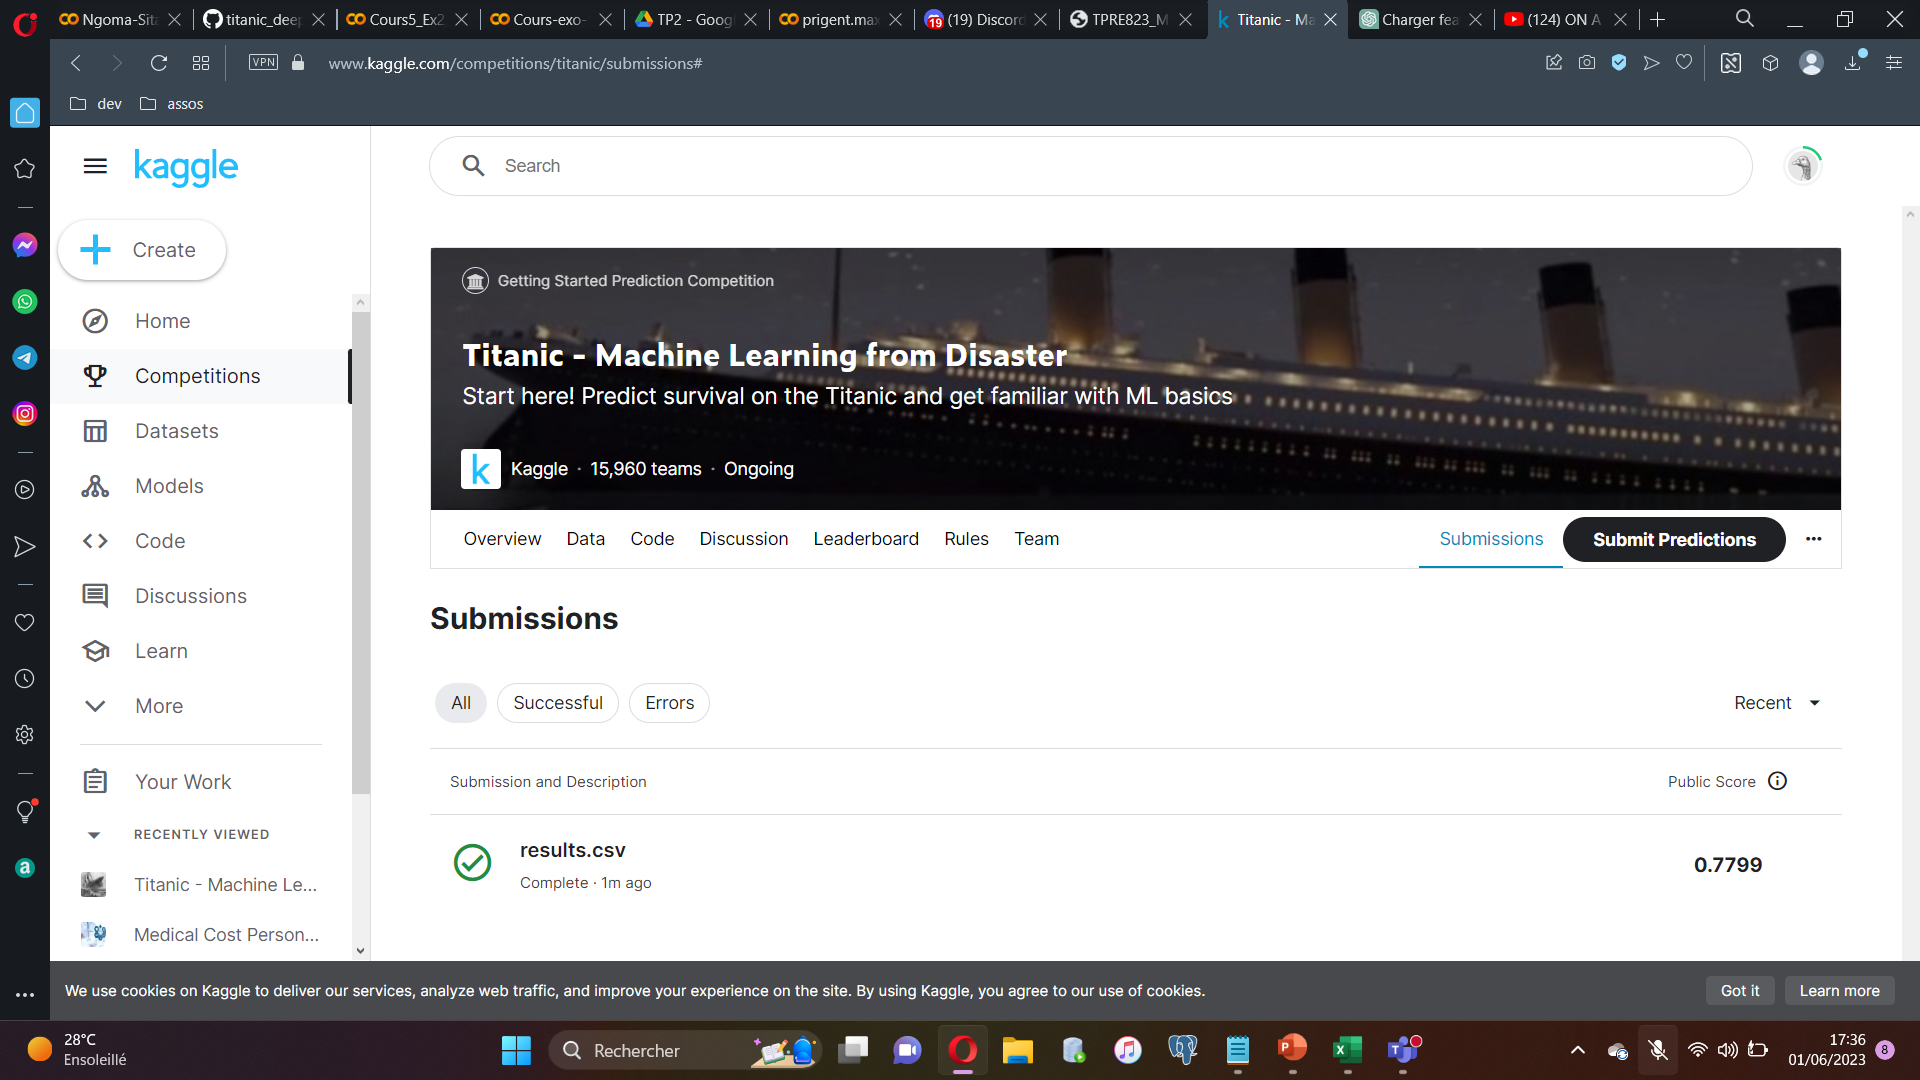

3.5 (Optionnel) Exécuter une Cross Validationd ans une boucle pour trouver les meilleures valeurs de learning rate, de keep_prob et de nombre d'epochs.

Cross_Validation avec skkearn : https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators